# Ablation Study - Feature Importance Analysis
## Iris Flower Classification

Nhận xét tầm quan trọng của từng feature bằng cách loại bỏ từng feature một và kiểm tra độ chính xác

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from itertools import combinations

# Thêm path để import modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'models')))

from SoftMax import SoftMaxClassifier
from KNN import KNNClassifier
from Decision_Tree import DecisionTreeClassifier
from Naive_Bayes import GaussianNaiveBayesClassifier

# Cấu hình
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

TRAIN_FILE = '../../data/IRIS_train.csv'
TEST_FILE = '../../data/IRIS_test.csv'

ALL_FEATURES = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data và Baseline Models

In [66]:
# Load data
print("Loading data...")
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

X_train = df_train[ALL_FEATURES].values
y_train = df_train['species'].values
X_test = df_test[ALL_FEATURES].values
y_test = df_test['species'].values

print(f"Train: {len(df_train)} samples | Test: {len(df_test)} samples")
print(f"Features: {ALL_FEATURES}")
print(f"Classes: {np.unique(y_test)}")

Loading data...
Train: 120 samples | Test: 30 samples
Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Classes: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [67]:
# Train baseline models với tất cả features
print("\n" + "="*60)
print("BASELINE MODELS - All Features")
print("="*60)

# SoftMax
softmax_baseline = SoftMaxClassifier(learning_rate=0.01, epochs=3000, batch_size=10, feature_cols=ALL_FEATURES)
softmax_baseline.fit(X_train, softmax_baseline._to_onehot(y_train))
sm_acc_baseline = softmax_baseline.score(X_test, softmax_baseline._to_onehot(y_test))
print(f"SoftMax Baseline: {sm_acc_baseline:.2f}%")

# KNN
knn_baseline = KNNClassifier(random_state=42, feature_cols=ALL_FEATURES)
knn_baseline.fit(df_train, k_range=range(1, 31), n_folds=5)
knn_acc_baseline = knn_baseline.score(df_test) * 100
print(f"KNN Baseline (k={knn_baseline.best_k}): {knn_acc_baseline:.2f}%")

# Decision Tree
dt_baseline = DecisionTreeClassifier(max_depth=None, criterion="entropy", feature_cols=ALL_FEATURES)
dt_baseline.fit(X_train, y_train)
dt_acc_baseline = dt_baseline.score(X_test, y_test) * 100
print(f"Decision Tree Baseline: {dt_acc_baseline:.2f}%")

# Naive Bayes
nb_baseline = GaussianNaiveBayesClassifier(feature_cols=ALL_FEATURES)
nb_baseline.fit(X_train, y_train)
nb_acc_baseline = nb_baseline.score(X_test, y_test) * 100
print(f"Naive Bayes Baseline: {nb_acc_baseline:.2f}%")


BASELINE MODELS - All Features
Training Mini-Batch (Batch Size: 10, Epochs: 3000)...
Epoch 0: Loss = 1.0953
Epoch 100: Loss = 0.7156
Epoch 200: Loss = 0.5804
Epoch 300: Loss = 0.5092
Epoch 400: Loss = 0.4632
Epoch 500: Loss = 0.4298
Epoch 600: Loss = 0.4038
Epoch 700: Loss = 0.3826
Epoch 800: Loss = 0.3647
Epoch 900: Loss = 0.3494
Epoch 1000: Loss = 0.3361
Epoch 1100: Loss = 0.3241
Epoch 1200: Loss = 0.3135
Epoch 1300: Loss = 0.3037
Epoch 1400: Loss = 0.2949
Epoch 1500: Loss = 0.2867
Epoch 1600: Loss = 0.2792
Epoch 1700: Loss = 0.2722
Epoch 1800: Loss = 0.2658
Epoch 1900: Loss = 0.2598
Epoch 2000: Loss = 0.2540
Epoch 2100: Loss = 0.2486
Epoch 2200: Loss = 0.2436
Epoch 2300: Loss = 0.2388
Epoch 2400: Loss = 0.2342
Epoch 2500: Loss = 0.2300
Epoch 2600: Loss = 0.2258
Epoch 2700: Loss = 0.2220
Epoch 2800: Loss = 0.2182
Epoch 2900: Loss = 0.2147
SoftMax Baseline: 93.33%
Chọn K bằng 5-Fold Cross-Validation trên tập train:
  k |   Accuracy (CV)
-------------------------
  1 |          0.9500

## 2. Ablation Study - Remove One Feature at a Time

In [68]:
# Ablation: Loại bỏ từng feature một
ablation_results = {
    'SoftMax': {},
    'KNN': {},
    'Decision Tree': {},
    'Naive Bayes': {}
}

print("\n" + "="*60)
print("ABLATION STUDY - Removing One Feature at a Time")
print("="*60)

for feature_to_remove in ALL_FEATURES:
    # Features không bao gồm feature bị loại
    remaining_features = [f for f in ALL_FEATURES if f != feature_to_remove]
    remaining_indices = [i for i, f in enumerate(ALL_FEATURES) if f != feature_to_remove]
    
    print(f"\n--- Without {feature_to_remove} ---")
    print(f"Remaining features: {remaining_features}")
    
    X_train_ablated = X_train[:, remaining_indices]
    X_test_ablated = X_test[:, remaining_indices]
    
    # SoftMax
    sm_ablated = SoftMaxClassifier(learning_rate=0.01, epochs=3000, batch_size=10, feature_cols=remaining_features)
    sm_ablated.fit(X_train_ablated, sm_ablated._to_onehot(y_train))
    sm_acc = sm_ablated.score(X_test_ablated, sm_ablated._to_onehot(y_test))
    sm_drop = sm_acc_baseline - sm_acc
    ablation_results['SoftMax'][feature_to_remove] = (sm_acc, sm_drop)
    
    # KNN
    df_train_ablated = df_train[remaining_features + ['species']].copy()
    df_test_ablated = df_test[remaining_features + ['species']].copy()
    knn_ablated = KNNClassifier(random_state=42, k=knn_baseline.best_k, feature_cols=remaining_features)
    knn_ablated.fit(df_train_ablated, k_range=[knn_baseline.best_k], n_folds=5)
    knn_acc = knn_ablated.score(df_test_ablated) * 100
    knn_drop = knn_acc_baseline - knn_acc
    ablation_results['KNN'][feature_to_remove] = (knn_acc, knn_drop)
    
    # Decision Tree
    dt_ablated = DecisionTreeClassifier(max_depth=None, criterion="entropy", feature_cols=remaining_features)
    dt_ablated.fit(X_train_ablated, y_train)
    dt_acc = dt_ablated.score(X_test_ablated, y_test) * 100
    dt_drop = dt_acc_baseline - dt_acc
    ablation_results['Decision Tree'][feature_to_remove] = (dt_acc, dt_drop)
    
    # Naive Bayes
    nb_ablated = GaussianNaiveBayesClassifier(feature_cols=remaining_features)
    nb_ablated.fit(X_train_ablated, y_train)
    nb_acc = nb_ablated.score(X_test_ablated, y_test) * 100
    nb_drop = nb_acc_baseline - nb_acc
    ablation_results['Naive Bayes'][feature_to_remove] = (nb_acc, nb_drop)
    
    print(f"SoftMax:       {sm_acc:.2f}% (↓ {sm_drop:.2f}%)")
    print(f"KNN:           {knn_acc:.2f}% (↓ {knn_drop:.2f}%)")
    print(f"Decision Tree: {dt_acc:.2f}% (↓ {dt_drop:.2f}%)")
    print(f"Naive Bayes:   {nb_acc:.2f}% (↓ {nb_drop:.2f}%)")


ABLATION STUDY - Removing One Feature at a Time

--- Without sepal_length ---
Remaining features: ['sepal_width', 'petal_length', 'petal_width']
Training Mini-Batch (Batch Size: 10, Epochs: 3000)...
Epoch 0: Loss = 1.0958
Epoch 100: Loss = 0.7311
Epoch 200: Loss = 0.5934
Epoch 300: Loss = 0.5200
Epoch 400: Loss = 0.4723
Epoch 500: Loss = 0.4378
Epoch 600: Loss = 0.4109
Epoch 700: Loss = 0.3889
Epoch 800: Loss = 0.3704
Epoch 900: Loss = 0.3547
Epoch 1000: Loss = 0.3408
Epoch 1100: Loss = 0.3286
Epoch 1200: Loss = 0.3177
Epoch 1300: Loss = 0.3077
Epoch 1400: Loss = 0.2987
Epoch 1500: Loss = 0.2904
Epoch 1600: Loss = 0.2827
Epoch 1700: Loss = 0.2756
Epoch 1800: Loss = 0.2690
Epoch 1900: Loss = 0.2628
Epoch 2000: Loss = 0.2571
Epoch 2100: Loss = 0.2517
Epoch 2200: Loss = 0.2465
Epoch 2300: Loss = 0.2416
Epoch 2400: Loss = 0.2372
Epoch 2500: Loss = 0.2329
Epoch 2600: Loss = 0.2287
Epoch 2700: Loss = 0.2248
Epoch 2800: Loss = 0.2211
Epoch 2900: Loss = 0.2175
Sử dụng k = 3 (đã chỉ định)
Trai

## 3. Visualization - Feature Importance

C:\Users\phucb\AppData\Local\Temp\ipykernel_20296\2851536502.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(features, rotation=45, ha='right')
C:\Users\phucb\AppData\Local\Temp\ipykernel_20296\2851536502.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(features, rotation=45, ha='right')
C:\Users\phucb\AppData\Local\Temp\ipykernel_20296\2851536502.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(features, rotation=45, ha='right')
C:\Users\phucb\AppData\Local\Temp\ipykernel_20296\2851536502.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(features, rotation=45, ha='

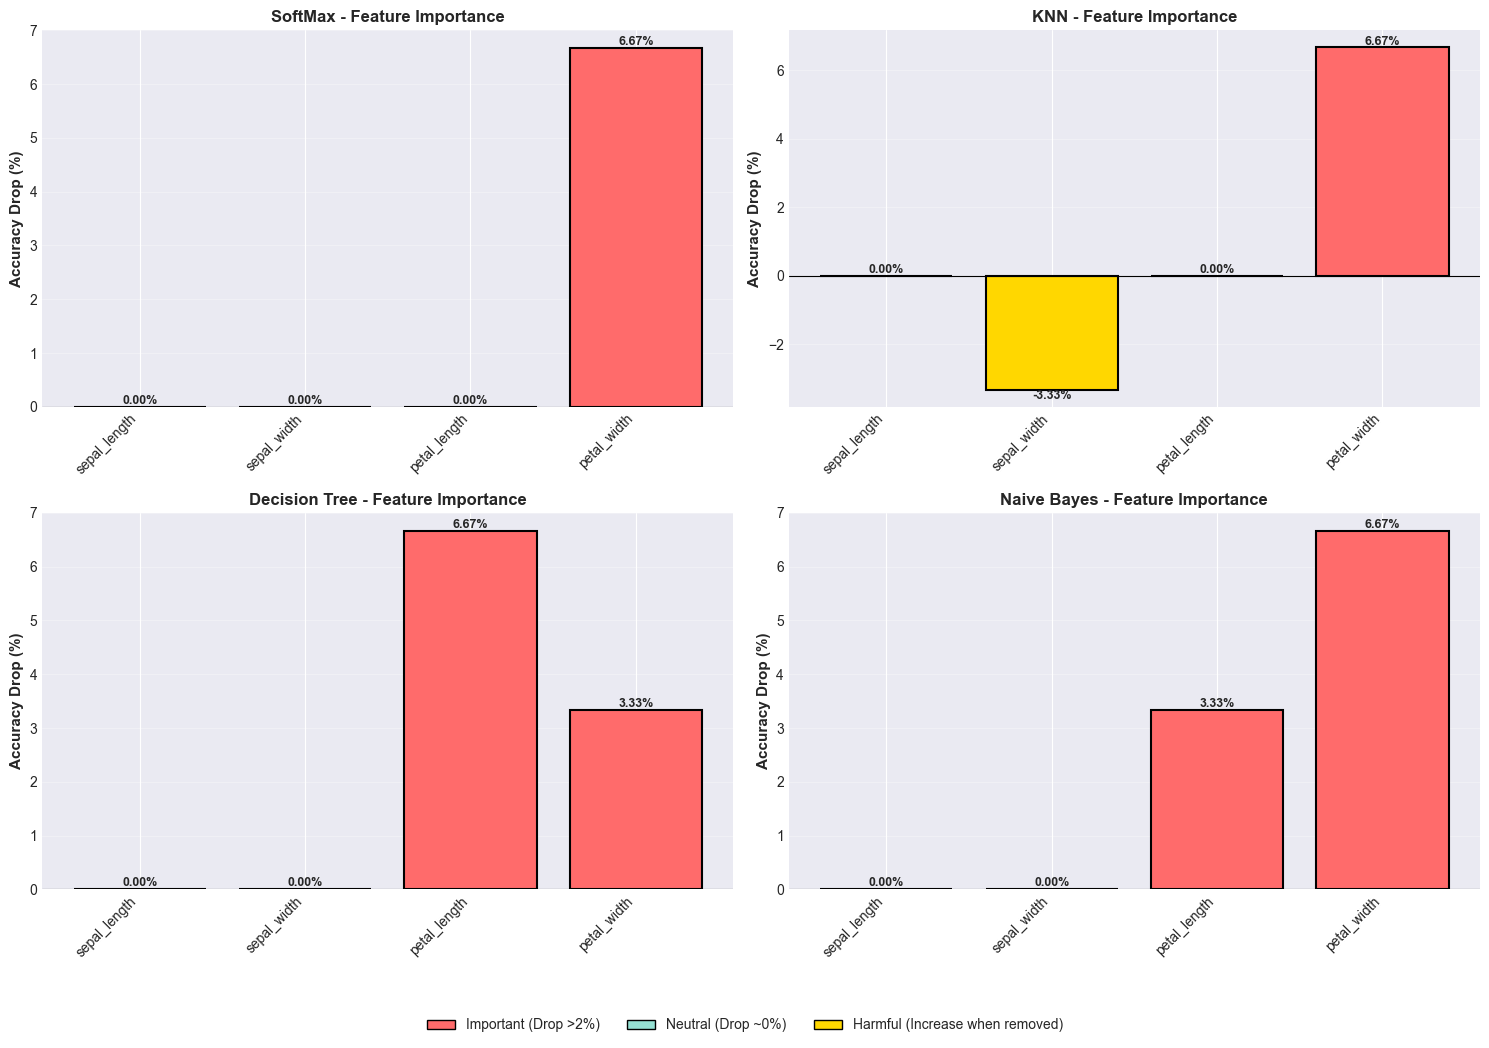


Feature importance visualization complete!
Red = Quan trọng | Green = Không ảnh hưởng | Yellow = Gây hại


In [69]:
# Create feature importance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

model_names = ['SoftMax', 'KNN', 'Decision Tree', 'Naive Bayes']

for idx, (ax, model_name) in enumerate(zip(axes.flat, model_names)):
    # Lấy dữ liệu performance drop cho mỗi feature
    feature_drops = ablation_results[model_name]
    features = list(feature_drops.keys())
    drops = [feature_drops[f][1] for f in features]
    
    # Tạo bar chart với color khác biệt rõ ràng
    # Drop dương (accuracy giảm) = Đỏ (feature quan trọng)
    # Drop âm (accuracy tăng) = Vàng cam (feature gây hại/noise)
    # Drop gần 0 = Xanh nhạt (không ảnh hưởng)
    colors = []
    for d in drops:
        if d > 0.02:  # Giảm >2%
            colors.append('#FF6B6B')  # Đỏ - feature quan trọng
        elif d < -0.02:  # Tăng >2%
            colors.append('#FFD700')  # Vàng cam - feature gây hại
        else:  # Gần 0
            colors.append('#95E1D3')  # Xanh - không ảnh hưởng
    
    bars = ax.bar(features, drops, color=colors, edgecolor='black', linewidth=1.5)
    
    # Customize
    ax.set_ylabel('Accuracy Drop (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name} - Feature Importance', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    # Thêm giá trị trên bars
    for bar, drop in zip(bars, drops):
        height = bar.get_height()
        label = f'{drop:.2f}%' if drop >= 0 else f'{drop:.2f}%'
        ax.text(bar.get_x() + bar.get_width()/2., height,
               label, ha='center', va='bottom' if drop >= 0 else 'top', 
               fontweight='bold', fontsize=9)
    
    # Rotate x labels
    ax.set_xticklabels(features, rotation=45, ha='right')

# Thêm legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF6B6B', edgecolor='black', label='Important (Drop >2%)'),
    Patch(facecolor='#95E1D3', edgecolor='black', label='Neutral (Drop ~0%)'),
    Patch(facecolor='#FFD700', edgecolor='black', label='Harmful (Increase when removed)')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), fontsize=10)

plt.tight_layout(rect=[0, 0.02, 1, 1])
plt.show()

print("\nFeature importance visualization complete!")
print("Red = Quan trọng | Green = Không ảnh hưởng | Yellow = Gây hại")


In [70]:
# Create summary table
print("\n" + "="*100)
print("ABLATION STUDY SUMMARY - Performance Drop (%) when removing each feature")
print("="*100)

# Prepare data for table
summary_data = []
for feature in ALL_FEATURES:
    row = {'Feature Removed': feature}
    for model_name in model_names:
        _, drop = ablation_results[model_name][feature]
        # Highlight nếu drop âm (tăng accuracy)
        if drop < -0.02:
            row[model_name] = f"↑ {-drop:.2f}%"  # Hiển thị tăng
        else:
            row[model_name] = f"{drop:.2f}%"
    summary_data.append(row)

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

# Average feature importance
print("\n" + "="*100)
print("AVERAGE FEATURE IMPORTANCE (Average accuracy drop across all models)")
print("="*100)

avg_importance = {}
for feature in ALL_FEATURES:
    drops = [ablation_results[model][feature][1] for model in model_names]
    avg_importance[feature] = np.mean(drops)

# Sort by importance
sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)

for i, (feature, importance) in enumerate(sorted_features, 1):
    if importance > 0.02:
        print(f"{i}. {feature:20s}: {importance:>7.2f}% (Important)")
    elif importance < -0.02:
        print(f"{i}. {feature:20s}: {importance:>7.2f}% (Harmful - Causes improvement when removed)")
    else:
        print(f"{i}. {feature:20s}: {importance:>7.2f}% (Neutral)")

print("="*100)



ABLATION STUDY SUMMARY - Performance Drop (%) when removing each feature
Feature Removed SoftMax     KNN Decision Tree Naive Bayes
   sepal_length   0.00%   0.00%         0.00%       0.00%
    sepal_width   0.00% ↑ 3.33%         0.00%       0.00%
   petal_length   0.00%   0.00%         6.67%       3.33%
    petal_width   6.67%   6.67%         3.33%       6.67%

AVERAGE FEATURE IMPORTANCE (Average accuracy drop across all models)
1. petal_width         :    5.83% (Important)
2. petal_length        :    2.50% (Important)
3. sepal_length        :    0.00% (Neutral)
4. sepal_width         :   -0.83% (Harmful - Causes improvement when removed)


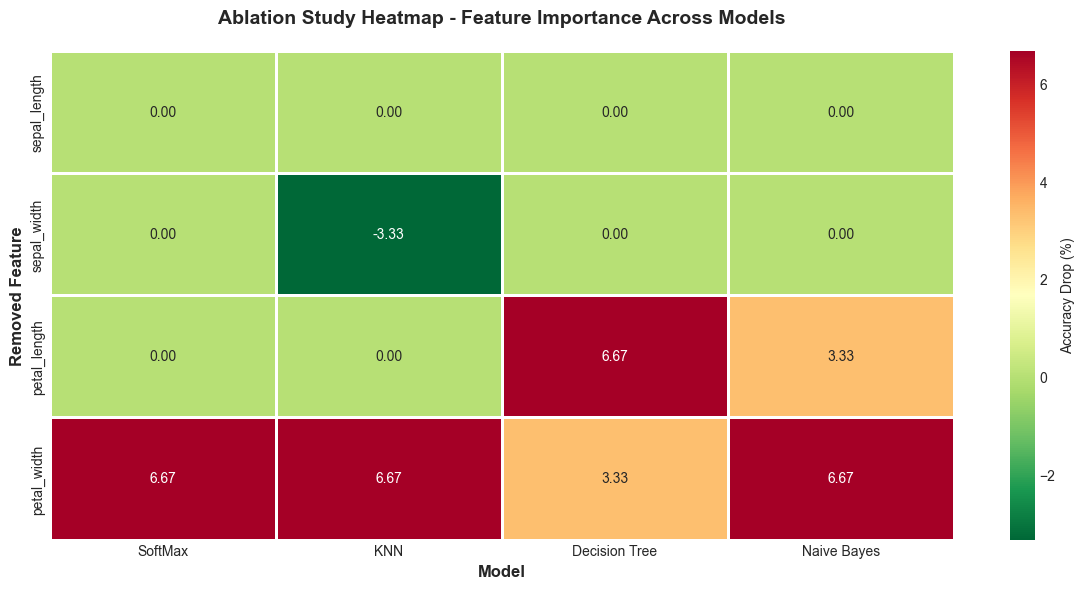

In [71]:
# Heatmap visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for heatmap
heatmap_data = []
for feature in ALL_FEATURES:
    row = [ablation_results[model][feature][1] for model in model_names]
    heatmap_data.append(row)

heatmap_data = np.array(heatmap_data)

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn_r', cbar_kws={'label': 'Accuracy Drop (%)'}, 
            xticklabels=model_names, yticklabels=ALL_FEATURES, ax=ax, linewidths=1, linecolor='white')

ax.set_title('Ablation Study Heatmap - Feature Importance Across Models', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Removed Feature', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

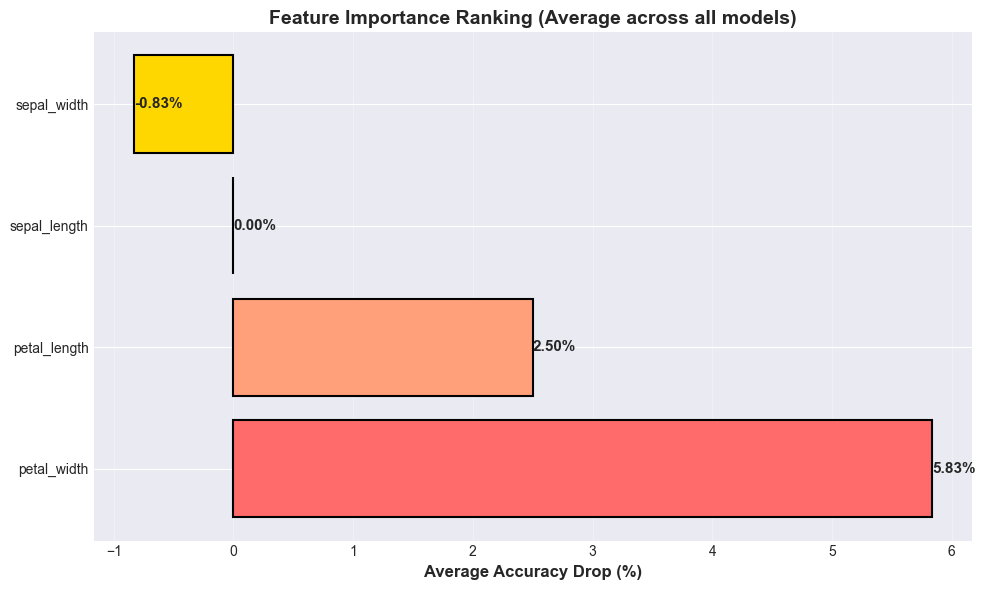

In [72]:
# Bar chart - Average feature importance
fig, ax = plt.subplots(figsize=(10, 6))

features = [f[0] for f in sorted_features]
importances = [f[1] for f in sorted_features]

bars = ax.barh(features, importances, color=['#FF6B6B', '#FFA07A', '#FFB347', '#FFD700'], edgecolor='black', linewidth=1.5)

ax.set_xlabel('Average Accuracy Drop (%)', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance Ranking (Average across all models)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Thêm giá trị trên bars
for bar, imp in zip(bars, importances):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
           f'{imp:.2f}%', ha='left', va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

## 4. Detailed Analysis Per Model

In [73]:
# Detailed per-model analysis
for model_name in model_names:
    print(f"\n{'='*70}")
    print(f"{model_name}")
    print(f"{'='*70}")
    
    # Get baseline accuracy
    if model_name == 'SoftMax':
        baseline = sm_acc_baseline
    elif model_name == 'KNN':
        baseline = knn_acc_baseline
    elif model_name == 'Decision Tree':
        baseline = dt_acc_baseline
    else:
        baseline = nb_acc_baseline
    
    print(f"Baseline Accuracy: {baseline:.2f}%\n")
    print(f"{'Feature':<20} {'Accuracy':<15} {'Drop':<15} {'Relative Drop':<15}")
    print("-" * 70)
    
    feature_drops = ablation_results[model_name]
    # Sort by importance
    sorted_ablations = sorted(feature_drops.items(), key=lambda x: x[1][1], reverse=True)
    
    for feature, (acc, drop) in sorted_ablations:
        relative_drop = (drop / baseline) * 100 if baseline > 0 else 0
        print(f"{feature:<20} {acc:>13.2f}% {drop:>13.2f}% {relative_drop:>13.2f}%")


SoftMax
Baseline Accuracy: 93.33%

Feature              Accuracy        Drop            Relative Drop  
----------------------------------------------------------------------
petal_width                  86.67%          6.67%          7.14%
sepal_length                 93.33%          0.00%          0.00%
sepal_width                  93.33%          0.00%          0.00%
petal_length                 93.33%          0.00%          0.00%

KNN
Baseline Accuracy: 93.33%

Feature              Accuracy        Drop            Relative Drop  
----------------------------------------------------------------------
petal_width                  86.67%          6.67%          7.14%
sepal_length                 93.33%          0.00%          0.00%
petal_length                 93.33%          0.00%          0.00%
sepal_width                  96.67%         -3.33%         -3.57%

Decision Tree
Baseline Accuracy: 96.67%

Feature              Accuracy        Drop            Relative Drop  
-------------

## 5. Key Findings & Conclusions

In [74]:
# Summary statistics
print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)

# Most important feature
most_important = sorted_features[0]
print(f"\n1. MOST IMPORTANT FEATURE: {most_important[0]}")
print(f"   Average accuracy drop when removed: {most_important[1]:.2f}%")

# Least important feature
least_important = sorted_features[-1]
print(f"\n2. LEAST IMPORTANT FEATURE: {least_important[0]}")
print(f"   Average accuracy drop when removed: {least_important[1]:.2f}%")

# Model comparison
print(f"\n3. MODEL SENSITIVITY TO FEATURES:")
model_sensitivities = {}
for model_name in model_names:
    drops = [ablation_results[model_name][f][1] for f in ALL_FEATURES]
    avg_drop = np.mean(drops)
    model_sensitivities[model_name] = avg_drop
    print(f"   {model_name:<20}: {avg_drop:.2f}% avg drop")

most_sensitive = max(model_sensitivities.items(), key=lambda x: x[1])
least_sensitive = min(model_sensitivities.items(), key=lambda x: x[1])
print(f"\n   Most sensitive model: {most_sensitive[0]} ({most_sensitive[1]:.2f}%)")
print(f"   Least sensitive model: {least_sensitive[0]} ({least_sensitive[1]:.2f}%)")

# Feature robustness
print(f"\n4. FEATURE ROBUSTNESS (Impact variability across models):")
for feature in ALL_FEATURES:
    drops = [ablation_results[model][feature][1] for model in model_names]
    std = np.std(drops)
    min_drop = np.min(drops)
    max_drop = np.max(drops)
    print(f"   {feature:<20}: std={std:.2f}%, range=[{min_drop:.2f}%, {max_drop:.2f}%]")

print("\n" + "="*70)


KEY FINDINGS

1. MOST IMPORTANT FEATURE: petal_width
   Average accuracy drop when removed: 5.83%

2. LEAST IMPORTANT FEATURE: sepal_width
   Average accuracy drop when removed: -0.83%

3. MODEL SENSITIVITY TO FEATURES:
   SoftMax             : 1.67% avg drop
   KNN                 : 0.83% avg drop
   Decision Tree       : 2.50% avg drop
   Naive Bayes         : 2.50% avg drop

   Most sensitive model: Decision Tree (2.50%)
   Least sensitive model: KNN (0.83%)

4. FEATURE ROBUSTNESS (Impact variability across models):
   sepal_length        : std=0.00%, range=[0.00%, 0.00%]
   sepal_width         : std=1.44%, range=[-3.33%, 0.00%]
   petal_length        : std=2.76%, range=[0.00%, 6.67%]
   petal_width         : std=1.44%, range=[3.33%, 6.67%]

